## Import Libarary Yang Dibutuhkan




In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,Input
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

## Uplode Kaggle.Json


In [ ]:
print('Upload Kaggle.json')

from google.colab import files
uploaded = files.upload()

# Membuat folder .kaggle jika belum ada untuk menyimpan kaggle.json
os.makedirs("/root/.kaggle", exist_ok=True)

# Memindahkan file kaggle.json ke direktori .kaggle agar bisa digunakan oleh Kaggle API
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

!chmod 600 /root/.kaggle/kaggle.json


Upload Kaggle.json


Saving kaggle.json to kaggle.json


## Data PreProcessing


In [ ]:
!kaggle datasets download -d imanuelsteven/animal-peek


Dataset URL: https://www.kaggle.com/datasets/imanuelsteven/animal-peek
License(s): MIT
 97% 289M/298M [00:02<00:00, 154MB/s]
100% 298M/298M [00:02<00:00, 139MB/s]


In [ ]:
import zipfile

# Mengekstrak file ZIP ke folder yang sesuai
with zipfile.ZipFile("animal-peek.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")  # Ekstrak ke dalam folder /content/dataset

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Mengubah ukuran gambar menjadi 224x224
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengubah dari BGR ke RGB
    image = image / 255.0  # Normalisasi gambar ke rentang [0, 1]
    return image

In [ ]:
data_path = '/content/dataset/Animal Peek/animals'
labels_path = '/content/dataset/Animal Peek/name of the animals.txt'

In [ ]:
# Membaca label dari file
with open(labels_path, 'r') as f:
    animal_names = f.read().split('\n')
    animal_names = [name for name in animal_names if name]  # Menghapus string kosong jika ada
    print(animal_names)

# Proses gambar dan label
data = []
label = []

for animal in animal_names:
    animal_path = os.path.join(data_path, animal)

    if os.path.isdir(animal_path):
        for image_name in os.listdir(animal_path):
            image_path = os.path.join(animal_path, image_name)
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image = preprocess_image(image_path)
                data.append(image)
                label.append(animal)

# Ubah Data Menjadi Numpy Array
data = np.array(data)
label = np.array(label)

print ('Total image : ', len(data))
print ('Total label : ', len(label))


['bat', 'bear', 'bee', 'beetle', 'butterfly', 'cat', 'caterpillar', 'cockroach', 'cow', 'crab', 'dog', 'dragonfly', 'duck', 'elephant', 'fly', 'goat', 'gorilla', 'grasshopper', 'hamster', 'hippopotamus', 'horse', 'ladybugs', 'lion', 'lizard', 'monkey', 'mouse', 'panda', 'pig', 'pigeon', 'rhinoceros', 'snake', 'sparrow', 'tiger', 'turkey', 'zebra']
Total image :  7271
Total label :  7271


In [ ]:
# ubah label menjadi angka
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(label)

len(labels)

7271

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42, shuffle=True, stratify=labels)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6180, 224, 224, 3)
y_train shape: (6180,)
X_test shape: (1091, 224, 224, 3)
y_test shape: (1091,)


## Buat Function Yang Dibutuhkan


In [ ]:
def plot_training_history(history):
    """Plots the training and validation accuracy and loss curves.

    Args:
        history: The training history object returned by model.fit.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r-', label='Training Accuracy')  # red line for training accuracy
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')  # blue line for validation accuracy
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r-', label='Training Loss')  # red line for training loss
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')  # blue line for validation loss
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid

    plt.tight_layout()
    plt.show()


In [ ]:
# Callbacks

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
#Load Nasnet

def pretrained_model_Nasnet():
  pretrained_model = tf.keras.applications.NASNetMobile(
      include_top=False,
      input_shape=(224, 224, 3),
      weights='imagenet'
  )

  for layer in pretrained_model.layers:
    layer.trainable = False

  return pretrained_model

In [ ]:
#Final Model

def create_final_model(base_model, num_classes):
    """Creates final model by adding layers on top of the pretrained model using Sequential API.

    Args:
        base_model (tf.keras.Model): pre-trained NASNet model
        num_classes (int): number of classes for classification

    Returns:
        TensorFlow model: final model
    """

    # Create the Sequential model
    model = tf.keras.Sequential()

    # Add the pretrained base model without the top layers (include_top=False)
    model.add(base_model)  # NASNetMobile is added here

    # Flatten the output layer of the pretrained model to 1D
    model.add(tf.keras.layers.Flatten())

    # Add a fully connected layer with 1024 hidden units and ReLU activation
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    # Add a dropout layer with 20% dropout rate
    model.add(tf.keras.layers.Dropout(0.3))

    # Add the final softmax layer for classification
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
#Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
base_model = pretrained_model_Nasnet()

19993432/19993432 [==============================] - 0s 0us/step


In [ ]:
model = create_final_model(base_model, len(animal_names))

In [ ]:
#Fit Data Train ke Datagen
datagen.fit(X_train)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),  # Menggunakan data augmentasi
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Menggunakan early stopping
    shuffle=True  # Mengacak data setiap epoch
)

Epoch 1/10
387/387 [==============================] - 1141s 3s/step - loss: 1.2122 - accuracy: 0.6984 - val_loss: 0.5736 - val_accuracy: 0.8442
Epoch 2/10
387/387 [==============================] - 1114s 3s/step - loss: 0.7375 - accuracy: 0.8087 - val_loss: 0.6117 - val_accuracy: 0.8405
Epoch 3/10
387/387 [==============================] - 1107s 3s/step - loss: 0.6237 - accuracy: 0.8362 - val_loss: 0.5550 - val_accuracy: 0.8451
Epoch 4/10
387/387 [==============================] - 1107s 3s/step - loss: 0.4902 - accuracy: 0.8642 - val_loss: 0.5314 - val_accuracy: 0.8570
Epoch 5/10
387/387 [==============================] - 1108s 3s/step - loss: 0.4060 - accuracy: 0.8803 - val_loss: 0.5019 - val_accuracy: 0.8799
Epoch 6/10
387/387 [==============================] - 1108s 3s/step - loss: 0.4037 - accuracy: 0.8837 - val_loss: 0.5176 - val_accuracy: 0.8598
Epoch 7/10
387/387 [==============================] - 1102s 3s/step - loss: 0.3513 - accuracy: 0.8984 - val_loss: 0.4875 - val_accuracy:

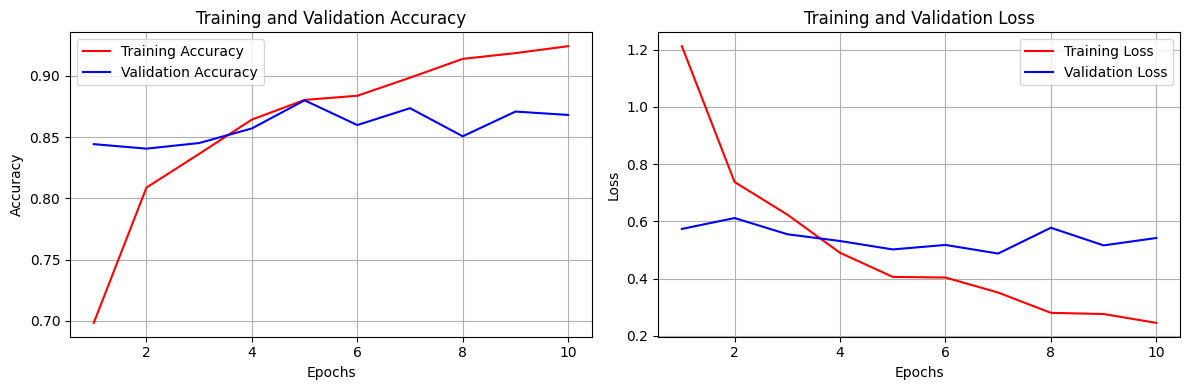

In [ ]:
  plot_training_history(history)

35/35 [==============================] - 79s 2s/step


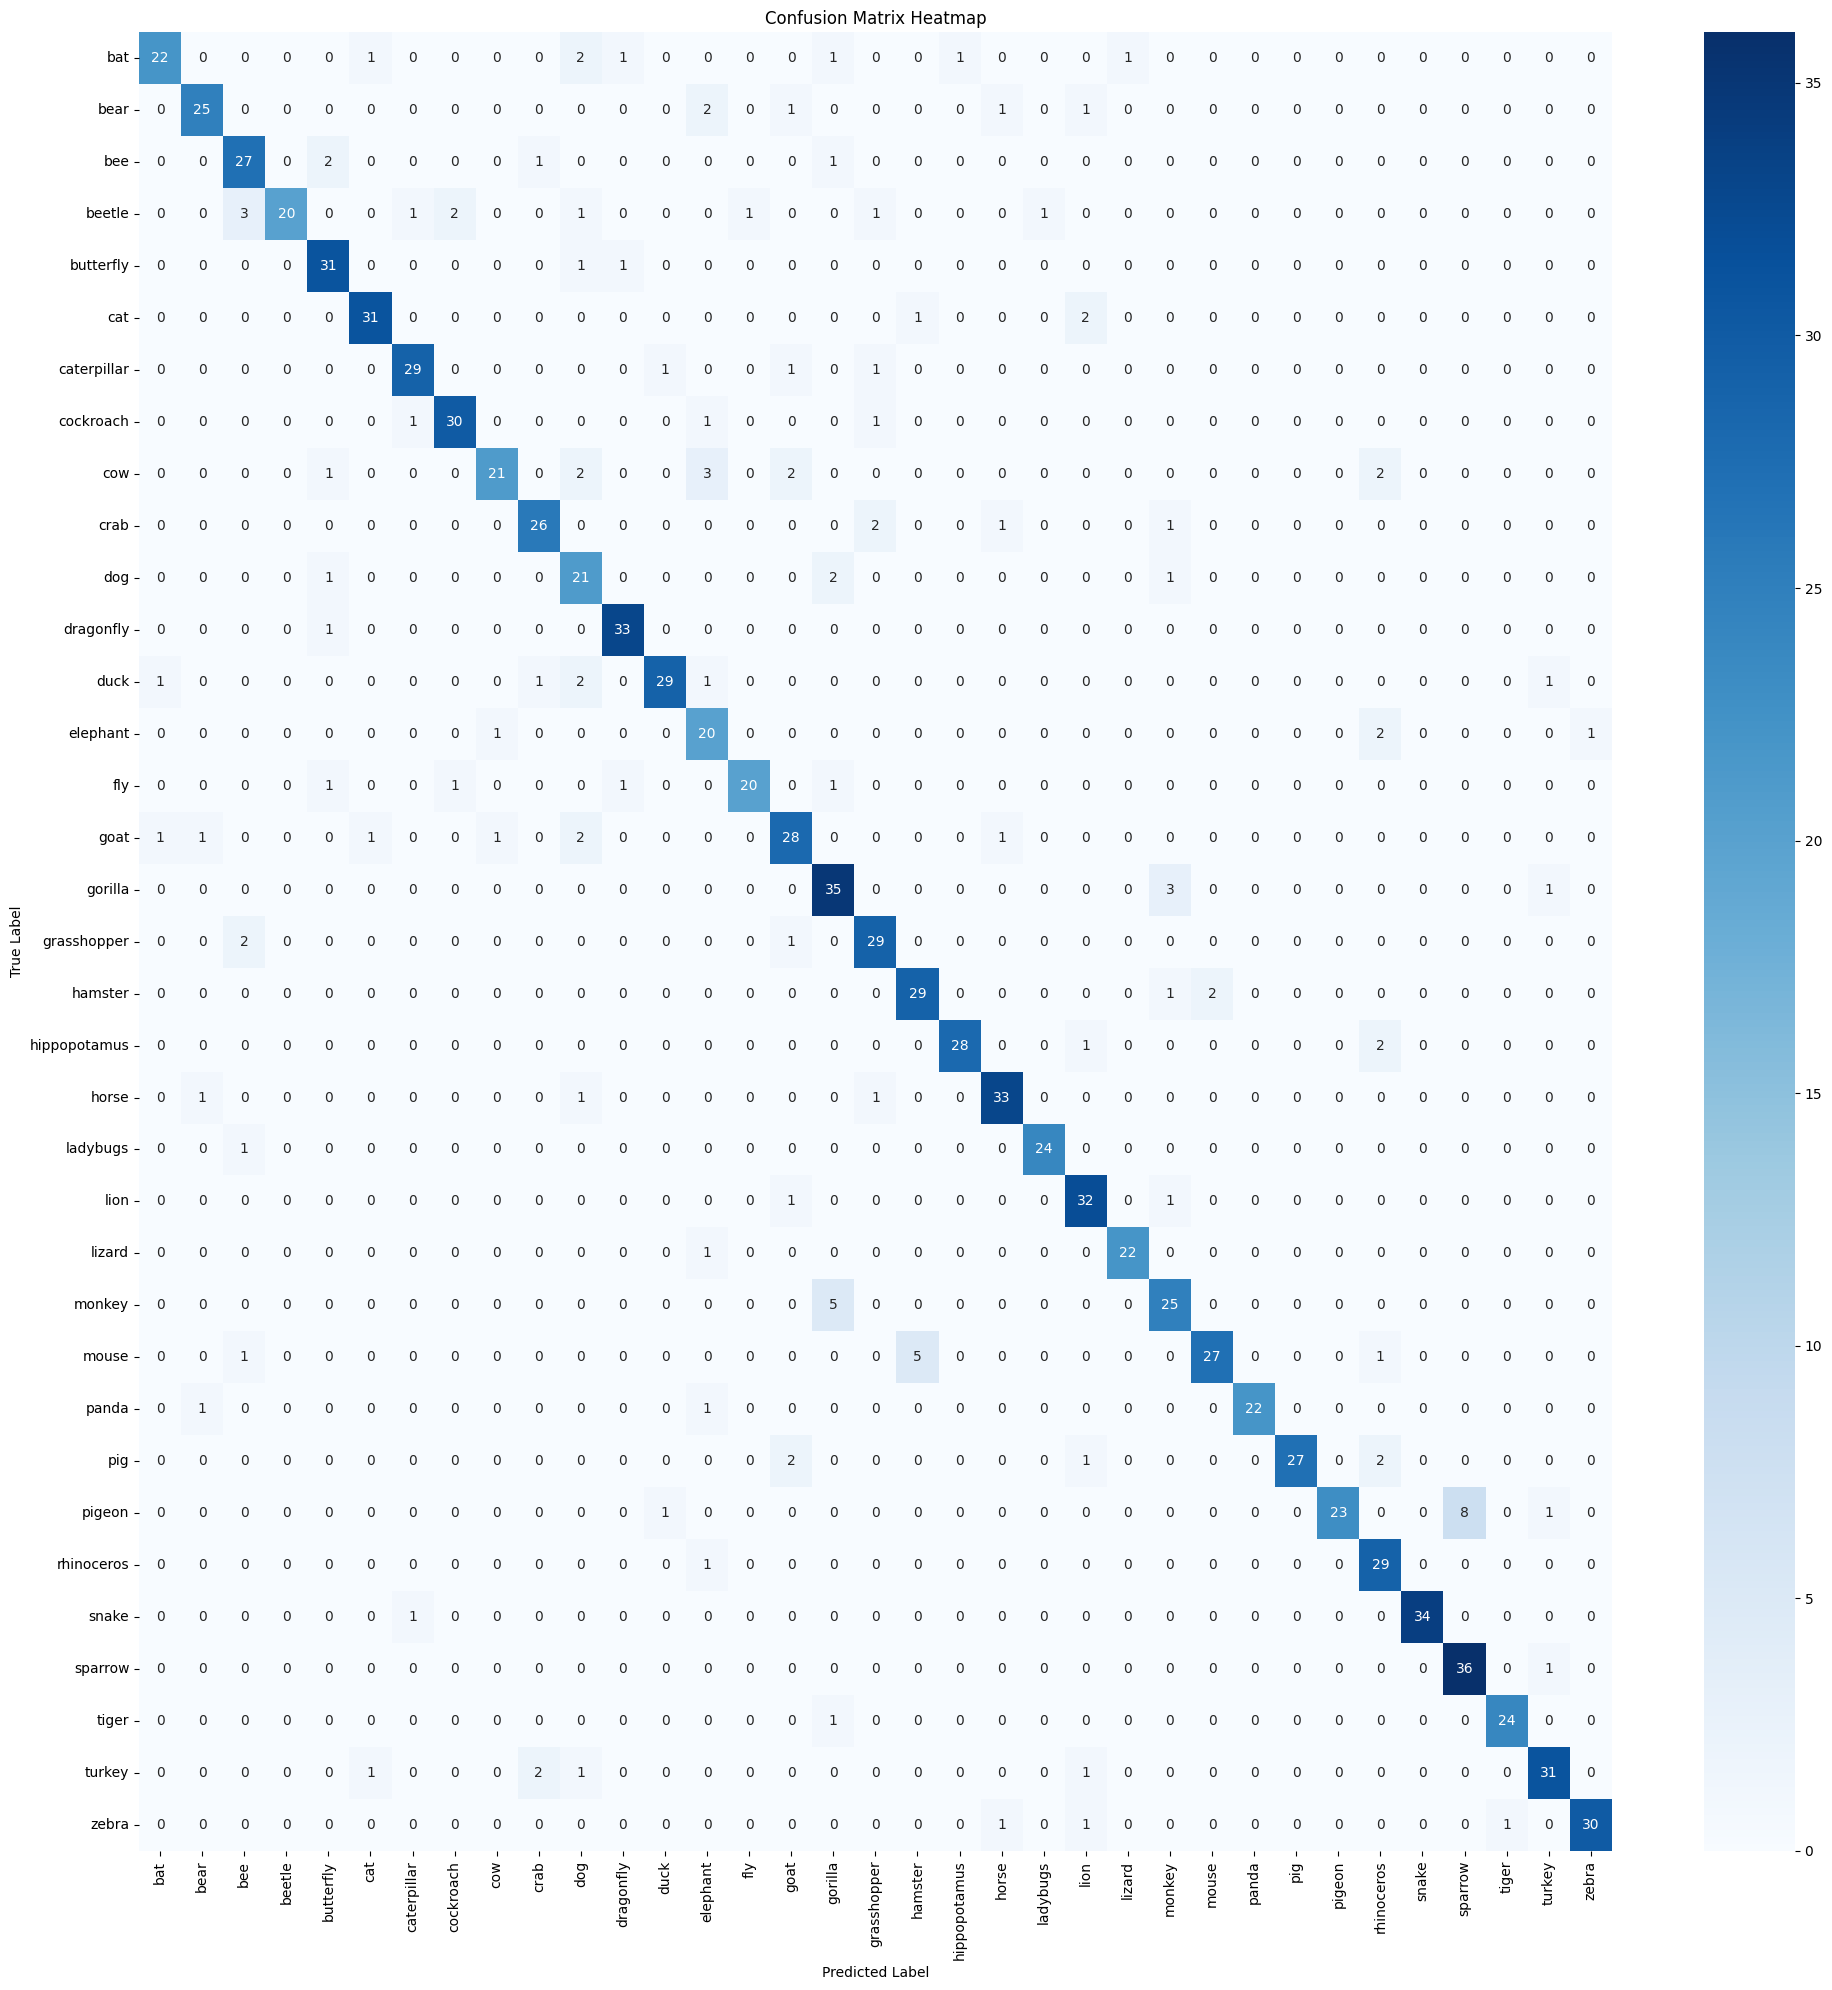

In [ ]:
#Misalnya, y_pred adalah prediksi model dan y_test adalah label yang sebenarnya
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# Menghitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=animal_names, yticklabels=animal_names)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
# Menghitung dan menampilkan classification report
report = classification_report(y_test, y_pred_classes, target_names=animal_names)
print(report)

In [ ]:
# Cek perbedaan antara y_test dan y_pred_classes (prediksi yang salah)
incorrect_indices = np.where(y_test != y_pred_classes)[0]

# Tampilkan gambar yang salah prediksi
for idx in incorrect_indices:
    img = X_test[idx]  # Ambil gambar dari X_test (data uji) yang diprediksi salah
    true_label = y_test[idx]  # Label asli
    predicted_label = y_pred_classes[idx]  # Prediksi model

    # Tampilkan gambar dan label yang benar/salah
    plt.imshow(img)  # Tampilkan gambar
    plt.title(f"True Label: {animal_names[true_label]}\nPredicted: {animal_names[predicted_label]}")
    plt.axis('off')  # Matikan axis
    plt.show()

This cell output is too large and can only be displayed while logged in.


Saving WhatsApp Image 2024-11-30 at 14.32.28.jpeg to WhatsApp Image 2024-11-30 at 14.32.28 (1).jpeg
1/1 [==============================] - 0s 87ms/step


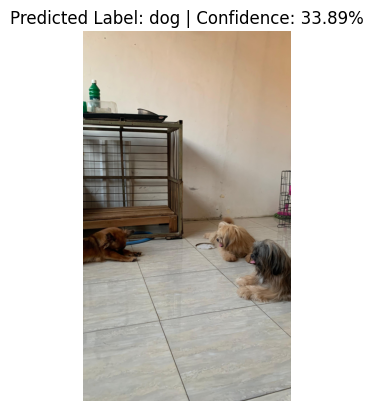

In [ ]:
from tensorflow.keras.preprocessing import image

# Fungsi untuk memprediksi gambar yang di-upload
def predict_image(uploaded_image_path):
    # Preprocess gambar
    img = preprocess_image(uploaded_image_path)

    # Tambahkan dimensi batch (model memerlukan input batch)
    img = np.expand_dims(img, axis=0)

    # Prediksi kelas gambar
    y_pred = model.predict(img)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

    # Ambil label yang sesuai dengan prediksi
    predicted_label = animal_names[y_pred_classes[0]]
    return predicted_label, y_pred[0][y_pred_classes[0]]

# Meng-upload gambar melalui Colab
uploaded = files.upload()

# Ambil nama file gambar yang di-upload
for fn in uploaded.keys():
    # Path gambar yang di-upload
    img_path = fn

    # Prediksi gambar
    label, probability = predict_image(img_path)

    # Tampilkan gambar dan hasil prediksi
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah kembali ke RGB untuk tampilan yang benar di Colab
    plt.imshow(img)
    plt.axis('off')  # Matikan axis
    plt.title(f"Predicted Label: {label} | Confidence: {probability*100:.2f}%")
    plt.show()
